# 프로젝트: 나랑 닮은 연예인을 찾아보자

## 🙋🏻‍♀️목표: 얼굴 이미지를 활용한 유사도 측정
* 임베딩에 대해 이해하고 얼굴의 임베딩 벡터를 추출합니다.
* 얼굴의 임베딩 벡터로 닮은 꼴인 얼굴을 찾습니다.
* 나와 가까운 연예인을 찾아냅니다.

## 🙋🏻‍♀️루브릭 
* 얼굴임베딩 벡터를 활용해 가장 닮은 연예인 Best 5를 구할 수 있다.
    - 닮은꼴 순위, 이름, 임베딩 거리를 포함한 Top-5 리스트가 정렬되어 출력되었다.(YES!)
* 충분한 수의 이미지에 대한 시도를 통해 매우 닮은꼴의 연예인을 찾아냈다.
    - 다양한 탐색을 통해 본인과 임베딩 거리 0.5 이내로 닮은 연예인을 찾아냈다. (YES!)
* 다양하고 재미있는 결과 시각화를 시도하였다.
    - matplotlib 등 다양한 시각화 도구를 하나 이상 이용해 재미있는 결과 시각화를 구현하였다. (YES!)
    
## 🙋🏻‍♀️프로젝트 Flow
* 데이터셋 구축
* 얼굴 영역 검출
    - Face Detection
    - Transform 
    - Crop
* 얼굴 영역 임베딩 추출
    - Get face embedding 
    - Get face embedding as dictionary 
* 얼굴 임베딩 벡터들간 거리 비교
* 시각화 

## 0. 사용 라이브러리 import

In [1]:
# # 사용할 라이브러리 설치 
# !pip install cmake
# !pip install dlib 
# !pip install face_recognition --user

In [2]:
import os
import face_recognition # 얼굴 인식 관련 딥러닝 라이브러리  

import numpy as np 

# 시각화 라이브러리 
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. 이미지에서 임베딩 벡터 딕셔너리까지 
* def get_cropped_face(image_file) : 이미지 파일에서 얼굴 영역을 가져오는 함수
* def get_face_embedding(face) : 얼굴영역으로부터 얼굴 임베딩 벡터를 구하는 함수
* def get_face_embedding_dict(dir_path) : 디렉토리 안에 있는 모든 이미지의 임베딩 딕셔너리를 구하는 함수
* def get_distance(name1, name2) : 두 이미지(사람 이름) 사이의 임베딩 벡터 거리를 구하는 함수

### 1.1. 얼굴인식 - 이미지 불러오기 및 얼굴영역 검출
이미지 경로로 이미지를 불러오고 face_recognition 라이브러리를 활용해서 이미지에서 얼굴 영역의 좌표를 검출합니다.

#### 프로젝트 디렉토리 생성

In [3]:
# import os # 위에서 이미 import 했습니다. 

project_path = os.getenv("HOME")+'/aiffel/face_embedding'

if not os.path.isdir(project_path):
    os.mkdir(project_path)
else:
    print("project_path에 폴더가 이미 존재합니다.")

project_path에 폴더가 이미 존재합니다.


In [4]:
image_path = project_path + '/images'

if not os.path.isdir(image_path):
    os.mkdir(image_path)
else:
    print("image_path에 폴더가 이미 존재합니다.")

image_path에 폴더가 이미 존재합니다.


#### 이미지 데이터 형태 살펴보기
face_location은 리스트[] 안에 튜플() 형태로 얼굴 영역에 해당하는 각 모서리의 좌표값이 들어가 있습니다.<br>
> 👀 [face_recognition.face_locations 함수란?](https://face-recognition.readthedocs.io/en/latest/face_recognition.html) <br>
Returns: A list of tuples of found face locations in css (top, right, bottom, left) order <br>

In [5]:
# test_image = face_recognition.load_image_file(image_path + '/test.png')
test_image = face_recognition.load_image_file(image_path + '/me.jpg')
face_locations = face_recognition.face_locations(test_image) # 사진에서 얼굴 영역을 추출합니다. 
print(face_locations)  # 이미지에서 얼굴 영역의 좌표를 출력합니다.

[(911, 1650, 1466, 1096)]


리스트 안의 튜플 값을 읽어오기 위해서 Index [0]을 통해 값을 받아옵니다. 그리고 해당 좌표값을 활용해 이미지를 슬라이싱합니다. 

In [6]:
test_image.shape # 720x1280에 3 channel(RGB) image

(4128, 3096, 3)

#### 이미지 출력해보기   
제 이모지를 활용해서 제 얼굴 이모지와 가장 닮은 연예인 사진을 찾아내볼겁니다!

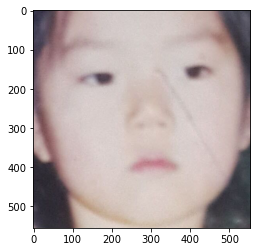

In [7]:
a, b, c, d = face_locations[0]
cropped_face = test_image[a:c,d:b,:] # a:c는 top to bottom, d:b는 left to right, RGB

plt.imshow(cropped_face)   # 이미지에서 얼굴영역만 잘라낸 cropped_face를 그려 봅니다.

위의 과정을 구현하는 함수를 작성합니다. 해당 함수는 이미지 파일로부터 얼굴 영역을 검출하는 함수 입니다. <br>
(주의사항) 추후에 이미지에서 얼굴 영역을 검출하지 못 했을 때 발생하는 오류 방지 코드가 필요합니다. 수희님 감사합니다:)

In [8]:
def get_cropped_face(image_path, image_file_name):
    image = face_recognition.load_image_file(os.path.join(image_path, image_file_name))
    face_locations = face_recognition.face_locations(image)
    a, b, c, d = face_locations[0]
    cropped_face = image[a:c,d:b,:]
    return cropped_face

### 1.2. FaceNet - 임베딩 벡터    
디렉토리 경로에 있는 파일 리스트를 불러오는 코드입니다. <br>
(주의사항) 코드를 짤 때 노드를 맹목적으로 따라가다보면 예제와 프로젝트간에 같은 내용의 변수를 여러번 선언하는 경우가 있습니다. <br> 
클린코드를 위해서는 이러한 점을 연습할때 최소화하는 편이 좋습니다. dir_path, image_path처럼 같은 변수가 여러번 선언되는 것을 방지합시다.<br>

In [9]:
# dir_path = os.getenv('HOME')+'/aiffel/face_embedding/images'
file_list = os.listdir(image_path)
print ("file_list: {}".format(file_list))

file_list: ['기성용.jpg', '제프리 힌턴.jpg', '잭 니콜슨.jpeg', '진.jpg', '이광수.jpg', '김남주.jpeg', '효정.jpg', '잭 블랙.jpeg', '톰 홀랜드.jpg', '하승진.jpg', '차명석.jpg', '이대호.jpeg', '배성우.png', '잇섭.png', '방시혁.jpeg', '레오나르도 디카프리오.jpeg', '개리.jpg', '박나래.jpeg', '산들.jpeg', '이근대위.jpeg', '이정재.jpeg', '심수창.jpeg', '박재범.jpg', '최무성.jpg', '트와이스쯔위.jpg', '차두리.jpeg', '트와이스미나.jpg', '저스틴 존슨.jpeg', '한효주.jpg', '김종서.jpg', '손예진.jpeg', '아린.jpg', '서현진.jpg', '최민식.jpg', '정민철.jpg', '김고은.jpeg', '티파니.jpg', '클린트 이스트우드.jpg', '세훈.jpg', '우기.jpg', '강민경.jpg', '줄리엔강.png', '봉준호.jpg', '이천수.jpg', '하정우.jpg', '신동엽.jpg', '로다주.jpeg', '화사.jpg', '민니.jpg', '윤아.jpg', '김현수.jpeg', '박보영.jpg', '지디.jpg', '잭 스페이더.jpeg', '레드벨벳웬디.jpg', '차승원.jpg', '수호.jpg', '솔라.jpg', '조정치.jpg', '야마다 타카유키.jpeg', '김연우.jpeg', '신비.jpg', '리암 니슨.png', '앤드류 응.png', '온앤오프효진.jpg', '켄 정.jpeg', '이효리.jpg', '첸.jpg', '디오.jpeg', '정준하.jpg', '윤종신.jpeg', '김유정.jpg', '윤도현.png', '노무현.jpeg', '정형돈.jpg', '장도연.jpg', '러블리즈지수.jpeg', '박항서.jpg', '차범근.jpeg', '조이.jpg', '도아.jpeg', '수지.jpg', '아놀드 슈워제네거.jpg', '슬리피.jpg',

face_recognition.face_encodings(): 얼굴 임베딩 벡터를 구하는 함수 <br>
> 왜 128차원인가?


In [10]:
# 얼굴 영역을 가지고 얼굴 임베딩 벡터를 구하는 함수
def get_face_embedding(face):
    return face_recognition.face_encodings(face)

### 1.3. 임베딩 벡터 to Dictionary

이미지의 임베딩을 구한 후 dictionary 구조에 담아 리턴하는 함수입니다. <br> 
> 👀 왜 Array로 쓰지 않고, Dictionary로 바꿀까? <br> 
필요에 의해서입니다. 프로젝트에서 입력으로 받는 것은 사람 이름입니다. 입력 대상이 사람이고 사람 간의 유사도를 측정해서 얼마나 닮았는지 벡터값을 보여주는게 출력입니다. 따라서 고정되는 값인 어떤 인덱스 역할을 해줄 국어사전의 ㄱ,ㄴ,ㄷ,ㄹ와 같은 존재는 여기서 이름입니다. 하지만 위에서 구한 임베딩 벡터는 array로 내부에 실수값만 줄줄이 나열되어 있습니다. 인덱스 역할을 해줄 '사람'이라는 문자열을 활용하고 이에 따라 각각 벡터를 매칭해주기 위해서는 key:value를 쓸 수 있는 딕셔너리가 써야하는 것입니다.

In [11]:
fail_list = [] # 얼굴 검출 실패 리스트 - 추후 테스트할 때 포함시키지 않도록 하기 위해 선언 

In [12]:
# 해당 경로에 있는 이미지 파일 모두를 얼굴 영역 검출 -> 임베딩 벡터 추출(get_face_embedding함수) -> 딕셔너리로 변환까지해주는 함수입니다. 
# 사람 이름: 임베딩 벡터 
def get_face_embedding_dict(image_path):
    file_list = os.listdir(image_path)
    embedding_dict = {}
    
    for image_file in file_list:
        try:
            face = get_cropped_face(image_path, image_file)
    #         if len(face) == 0: continue # 얼굴을 검출하지 못 하는 경우를 고려해서 문장길이가 0인 것은 pass 
            embedding = get_face_embedding(face)
            if len(embedding) > 0:  # 얼굴 영역을 검출한 후, 임베딩 벡터를 뽑아냈을 떄 0이상인 경우 임베딩 딕셔너리 생성
                embedding_dict[os.path.splitext(image_file)[0]] = embedding[0] # 리스트 
        except:
            fail_list.append(image_file)
    return embedding_dict

## 2. 거리 비교 함수 
### 2.1. 임베딩사이의 거리 측정 - L2 distance
CS231N 앞부분 강의를 들어보면 L2 distance에 대한 설명이 있었습니다. 피타고라스 정리를 사용하여 계산하는 유사도 측정 방법인데 거리가 짧으면 유사도가 더 높음을 의미합니다.<br>

In [13]:
def get_distance_l2(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=2)

# get_distance('obama', 'trump')

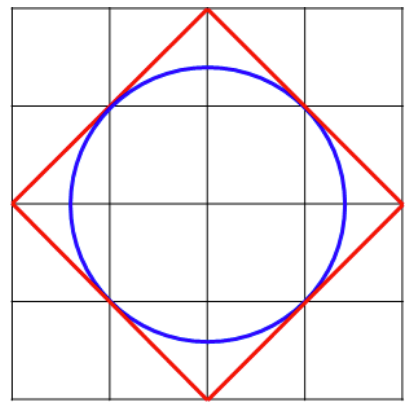
> 👀 L2가 아닌 L1으로 한다면?      
L1 distance는 제곱의 제곱근이 아니라 차의 절대값의 합으로 계산됩니다. 따라서 L2보다 전체적인 거리값의 분포가 커지게 됩니다. 위의 그림에서 빨간선은 L1이고 파란선은 L2입니다. 그래프에서도 알 수 있듯이 L1이 분포가 더 큼을 알 수 있습니다. 코드를 통해 실험적으로 이를 확인해볼 수 있도록 L1 함수도 만들어 줍니다.
> 출처: https://gaussian37.github.io/dl-concept-regularization/ <br>

In [14]:
def get_distance_l1(name1, name2):
    return np.linalg.norm(embedding_dict[name1]-embedding_dict[name2], ord=1)

# get_distance('obama', 'trump')

### 2.2. 거리 순으로 정렬
get_sort_key_func은 name1을 인자로 받고, 반환값은 get_distance_from_name1입니다. 그리고 이 반환값은 중첩 함수(Nested Function)인 get_distance_from_name1입니다. <br>

|입력|함수|출력|     
|:---------------:|:-----------:|:-----------:|     
|name1|get_sort_key_func|get_distance_from_name1|    
|name2|get_distance_from_name1|get_distance(name1, name2)|


In [15]:
def get_sort_key_func(name1, norm):
    def get_distance_from_name1(name2):
        if norm == 'l1':
            return get_distance_l1(name1, name2)
        else: # 기본: l2,  norm == 'l2'
            return get_distance_l2(name1, name2) 
    return get_distance_from_name1

### 2.3. 가장 가까운 Top5와 가장 먼 bottom5 출력
아래 수행되는 함수들의 결과는 가장 닮은 또는 안 닮은 연예인 랭킹을 뽑아줍니다. <br>
```
get_nearest_face('trump')
>> 수행결과
순위 1 : 이름(biden), 거리(0.682061661275583)
순위 2 : 이름(clinton), 거리(0.6875851008652103)
순위 3 : ... (이하생략)
```

In [16]:
def get_nearest_face(name, norm, top=5):
    sort_key_func = get_sort_key_func(name, norm)
    sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))
    print("***{} 닮은 얼굴 랭킹 5위***".format(name))
    for i in range(top+1):
        if i == 0 :   # 첫번째로 나오는 이름은 자기 자신일 것이므로 제외합시다. 
            continue
        if sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, sorted_faces[i][0], sort_key_func(sorted_faces[i][0])))
    return sorted_faces

In [17]:
def get_dissimilar_face(name, norm, bottom=5):
    sort_key_func = get_sort_key_func(name, norm)
    reverse_sorted_faces = sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]), reverse = True) # 역순
    print("***{} 안 닮은 얼굴 랭킹 5위***".format(name))  
    for i in range(bottom):
        if reverse_sorted_faces[i]:
            print('순위 {} : 이름({}), 거리({})'.format(i, reverse_sorted_faces[i][0], sort_key_func(reverse_sorted_faces[i][0])))
    return reverse_sorted_faces

## 3. Sample Test    
닮은꼴 찾기와 관련된 함수 정의를 모두 마쳤습니다. 함수가 잘 동작하는지 미국 대통령 이미지를 활용해서 먼저 테스트해보겠습니다. 

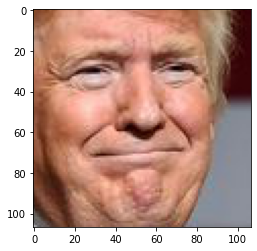

In [18]:
# 1. 기준 이미지 얼굴 영역만 출력해보기 
sample_path = project_path + '/samples'
sample_image = 'trump.jpg'
cropped_face = get_cropped_face(sample_path, sample_image)
plt.imshow(cropped_face)

In [19]:
# 2. 임베딩 벡터 구하기 
sample_embedding = get_face_embedding(cropped_face) 
sample_embedding[0].shape, sample_embedding[0][:3] # 128차원

((128,), array([-0.15962461,  0.20268646,  0.0323635 ]))

(주의사항) embedding 변수처럼 뜬금없이 Index[0]을 써줄 때는 데이터 형에 대해 확인해볼 필요가 있습니다. <br>
embedding이랑 embedding[0]이랑 같아 보이지만 실제로 type을 확인해보면 embedding 자체는 리스트고 그  안에 원소는 array인 것을 확인할 수 있습니다. <br> 따라서 embedding은 128 차원을 가지는 array 원소를 가지고 있는 리스트입니다.

In [20]:
type(sample_embedding)

list

In [21]:
type(sample_embedding[0])

numpy.ndarray

In [22]:
sample_embedding[0].shape

(128,)

데이터 형만 다를 뿐, 내용은 동일한 것을 알 수 있습니다.

In [23]:
sample_embedding == sample_embedding[0]

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

(주의사항) 여기서, 주의할 사항은 embedding_dict라는 변수는 지금 글로벌 변수이다. 함수 중에 get_distance_l1과 l2를 살펴보면 인자로 받지 않고 전역변수로서 사용되고 있음을 알 수 있습니다. 

In [24]:
# 3. 추출한 임베딩 벡터를 임베딩 벡터 딕셔너리 형태로 변환해주기 (아래 코드느 test 일환)
# 사람 이름: 임베딩 벡터 
embedding_dict =  get_face_embedding_dict(sample_path)
embedding_dict['trump'][:10]  # obama.jpg의 얼굴임베딩 벡터

array([-0.15962461,  0.20268646,  0.0323635 ,  0.02439233, -0.06226433,
        0.0514071 ,  0.07351793, -0.16823342,  0.06962212, -0.05557969])

In [25]:
embedding_dict = get_face_embedding_dict(sample_path)
embedding_dict['obama'][:10]  # trump.jpg의 얼굴임베딩 벡터

array([-0.08126269,  0.11014768, -0.01082436, -0.05268788,  0.01033718,
       -0.00813816, -0.07251763, -0.0922645 ,  0.19304708, -0.09246373])

In [26]:
# norm = l2일 때
norm = 'l2'

In [27]:
# 4. 전체 이미지 임베딩 벡터 구하기 & 거리 계산하기  
sort_key_func = get_sort_key_func('trump', norm) # name1 = 'obama', get_distance_from_name1(name2 = sort_key_func)

# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0]))[:10] 
print("🙋")

🙋


In [28]:
# obama와 가장 닮은 사람은 누굴까요?
sample_near_result = get_nearest_face('trump', norm)

***trump 닮은 얼굴 랭킹 5위***
순위 1 : 이름(reagan), 거리(0.6519150692248521)
순위 2 : 이름(biden), 거리(0.6820616110741761)
순위 3 : 이름(clinton), 거리(0.6875851052274939)
순위 4 : 이름(bush), 거리(0.7982715002338945)
순위 5 : 이름(obama), 거리(0.8885117257487282)


In [29]:
# obama와 가장 안 닮은 사람은 누굴까요?
sample_dis_result = get_dissimilar_face('trump', norm)

***trump 안 닮은 얼굴 랭킹 5위***
순위 0 : 이름(obama), 거리(0.8885117257487282)
순위 1 : 이름(bush), 거리(0.7982715002338945)
순위 2 : 이름(clinton), 거리(0.6875851052274939)
순위 3 : 이름(biden), 거리(0.6820616110741761)
순위 4 : 이름(reagan), 거리(0.6519150692248521)


In [30]:
# norm = l1일 때
norm = 'l1'

In [31]:
# 4. 전체 이미지 임베딩 벡터 구하기 & 거리 계산하기  
sort_key_func = get_sort_key_func('trump', norm) # name1 = 'obama', get_distance_from_name1(name2 = sort_key_func)

# 이렇게 생성된 함수 sort_key_func는 sort_key_func('obama') 라고 호출할 때 trump와 obama 사이의 임베딩 벡터 거리를 계산합니다.
sorted(embedding_dict.items(), key=lambda x:sort_key_func(x[0])) #

[('trump',
  array([-0.15962461,  0.20268646,  0.0323635 ,  0.02439233, -0.06226433,
          0.0514071 ,  0.07351793, -0.16823342,  0.06962212, -0.05557969,
          0.17270111, -0.05094172, -0.35293111, -0.03164376,  0.03792981,
          0.1734385 , -0.13260117, -0.15357369, -0.23523541, -0.08442697,
         -0.00134133,  0.03210668, -0.08926147, -0.02670787, -0.09581173,
         -0.25792357, -0.01057008, -0.11071666,  0.03133569, -0.07444929,
          0.05670558, -0.02273803, -0.19461133, -0.04576058,  0.00947578,
          0.01806064, -0.15026242, -0.07787319,  0.17577602,  0.01933261,
         -0.19744579, -0.03930514,  0.07374467,  0.20196031,  0.14767544,
         -0.01415385,  0.01724756, -0.11976208,  0.09462965, -0.2431815 ,
         -0.02755117,  0.12169883,  0.148377  ,  0.17079775,  0.06952556,
         -0.15360464,  0.02005422,  0.08199161, -0.19544823,  0.10653654,
          0.11468483, -0.21902835, -0.07677593, -0.06791041,  0.10587607,
          0.05921577, -0.06

In [32]:
# trump와 가장 닮은 사람은 누굴까요?
sample_near_result = get_nearest_face('trump', norm)
print("🙋")

***trump 닮은 얼굴 랭킹 5위***
순위 1 : 이름(reagan), 거리(5.980868854327127)
순위 2 : 이름(biden), 거리(6.083740994799882)
순위 3 : 이름(clinton), 거리(6.3366431726608425)
순위 4 : 이름(bush), 거리(7.284675740171224)
순위 5 : 이름(obama), 거리(8.173186462256126)
🙋


reverse = True로 파라미터를 설정해줌으로서 안 닮은 사람은 누구인지 알 수 있었습니다. 샘플에서는 trump를 기준으로 했을 때 거리가 가장 먼 obama가 안 닮은 사람 랭킹 1위를 차지했습니다.

In [33]:
# obama와 가장 안 닮은 사람은 누굴까요?
sample_dis_result = get_dissimilar_face('trump', norm)
print("🙋")

***trump 안 닮은 얼굴 랭킹 5위***
순위 0 : 이름(obama), 거리(8.173186462256126)
순위 1 : 이름(bush), 거리(7.284675740171224)
순위 2 : 이름(clinton), 거리(6.3366431726608425)
순위 3 : 이름(biden), 거리(6.083740994799882)
순위 4 : 이름(reagan), 거리(5.980868854327127)
🙋


## 4. Test & Result

### 4.1. 거리 비교 결과  
**def get_face_embedding_dict(image_path)로 face detection -> crop -> embedding vector -> embedding dictionary 순서로 이뤄진 결과물을 출력합니다.** <bn>

#### 이모지로 찾은 닮은꼴 

In [34]:
norm = 'l2'
embedding_dict = get_face_embedding_dict(image_path)

In [35]:
fail_list

['산들.jpeg']

In [36]:
test_near_result = get_nearest_face('test',norm)
print("🙋")

***test 닮은 얼굴 랭킹 5위***
순위 1 : 이름(우기), 거리(0.6152952586028857)
순위 2 : 이름(김고은), 거리(0.6168130033160919)
순위 3 : 이름(레드벨벳웬디), 거리(0.6209302634280468)
순위 4 : 이름(유아), 거리(0.627404447024498)
순위 5 : 이름(채연), 거리(0.6284294142556507)
🙋


In [37]:
test_dis_result = get_dissimilar_face('test', norm)
print("🙋")

***test 안 닮은 얼굴 랭킹 5위***
순위 0 : 이름(크리스 햄스워스), 거리(0.931316217662315)
순위 1 : 이름(드웨인 존슨), 거리(0.9108852706728308)
순위 2 : 이름(차두리), 거리(0.8992694685717403)
순위 3 : 이름(숀 코네리), 거리(0.8978391500284542)
순위 4 : 이름(김C), 거리(0.8936417670721718)
🙋


#### 어렸을 때 사진과 닮은꼴

In [38]:
me_near_result = get_nearest_face('me',norm)
print("🙋")

***me 닮은 얼굴 랭킹 5위***
순위 1 : 이름(me2), 거리(0.4192293602462896)
순위 2 : 이름(강미나), 거리(0.45372813052282795)
순위 3 : 이름(태연), 거리(0.4540909968601389)
순위 4 : 이름(목진화), 거리(0.45888048991161073)
순위 5 : 이름(공효진), 거리(0.4610037732990489)
🙋


In [39]:
me_dis_result = get_dissimilar_face('me', norm)
print("🙋")

***me 안 닮은 얼굴 랭킹 5위***
순위 0 : 이름(다니엘 크레이그), 거리(0.9137926711333928)
순위 1 : 이름(크리스 에반스), 거리(0.8973890620139549)
순위 2 : 이름(리암 니슨), 거리(0.8945899088703236)
순위 3 : 이름(크리스 햄스워스), 거리(0.8617271679574254)
순위 4 : 이름(잭 갤리퍼내키스), 거리(0.860561522004025)
🙋


#### 새로운 사진을 넣었을 떄 나를 찾을 수 있을까..?

In [40]:
me2_near_result = get_nearest_face('me2',norm)
print("🙋")

***me2 닮은 얼굴 랭킹 5위***
순위 1 : 이름(비니), 거리(0.38416431148462976)
순위 2 : 이름(me), 거리(0.4192293602462896)
순위 3 : 이름(공효진), 거리(0.4227724119671662)
순위 4 : 이름(우기), 거리(0.42641033735731393)
순위 5 : 이름(온앤오프라운), 거리(0.43173462716757016)
🙋


In [41]:
me2_dis_result = get_dissimilar_face('me2', norm)
print("🙋")

***me2 안 닮은 얼굴 랭킹 5위***
순위 0 : 이름(크리스 햄스워스), 거리(0.9857488274310612)
순위 1 : 이름(다니엘 크레이그), 거리(0.9703891178231867)
순위 2 : 이름(크리스 에반스), 거리(0.962063210640183)
순위 3 : 이름(잭 갤리퍼내키스), 거리(0.9402990074757013)
순위 4 : 이름(클린트 이스트우드), 거리(0.9354216206929687)
🙋


### 4.2. Visualization   
🙋🙋 어렸을 때와 크게 달라지지 않았음을 확인할 수 있었습니다. ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ

닮은꼴 상위 3명🙋🙋🙋


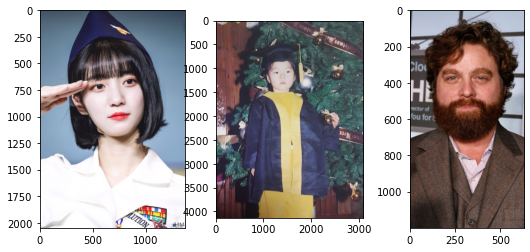

In [77]:
import matplotlib.image as img 

print("닮은꼴 상위 3명🙋🙋🙋")
plt.figure(figsize = (9, 4))

for image_file in file_list:
    image_name = image_file.split('.')[0]
    if image_name == str(me2_near_result[1][0]):
        plt.subplot(1,3,1)
        ndarray = img.imread(os.path.join(image_path,image_file))
        plt.imshow(ndarray)
        
    if image_name == str(me2_near_result[2][0]):
        plt.subplot(1,3,2)
        ndarray = img.imread(os.path.join(image_path,image_file))
        plt.imshow(ndarray)
        
    if image_name == str(me2_dis_result[3][0]):
        plt.subplot(1,3,3)
        ndarray = img.imread(os.path.join(image_path,image_file))    
        plt.imshow(ndarray)



닮은꼴 1등🙋과 꼴등🙋


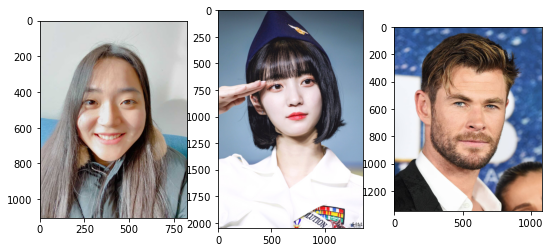

In [78]:
import matplotlib.image as img 

print("닮은꼴 1등🙋과 꼴등🙋")
plt.figure(figsize = (9, 4))

for image_file in file_list:
    image_name = image_file.split('.')[0]
    if image_name == str(me2_near_result[0][0]):
        plt.subplot(1,3,1)
        ndarray = img.imread(os.path.join(image_path,image_file))
        plt.imshow(ndarray)
        
    if image_name == str(me2_near_result[1][0]):
        plt.subplot(1,3,2)
        ndarray = img.imread(os.path.join(image_path,image_file))
        plt.imshow(ndarray)
        
    if image_name == str(me2_dis_result[0][0]):
        plt.subplot(1,3,3)
        ndarray = img.imread(os.path.join(image_path,image_file))    
        plt.imshow(ndarray)



## 5. 회고     
### 5.1. 난이도    
얼굴 인식 관련 라이브러리는 저번에 배운 dlib이나, 이번 Face_detection 라이브러리처럼 딥러닝 학습된 라이브러리를 가져와쓰기 때문에 직접 학습 모델을 설계하는게 아니라서 전반적인 난이도는 쉽게 느껴졌습니다.    

### 5.2. Debugging    
```
----> 4     a, b, c, d = face_locations[0]
      5     cropped_face = image[a:c,d:b,:]
      6     return cropped_face

IndexError: list index out of range
``` 
위와 같은 index Error가 나왔습니다. 수희님과 혜미님의 솔루션을 슬랙에서 참고하여 해결했습니다. <br>
해당 문제는 얼굴이 검출되지 않으면 face_locatin값이 없는데 Index[0]으로 인덱싱하는 거 때문에 나타나는 문제였습니다. 그래서 먼저 리스트에서 이미지를 검출하지 못 한 경우에 대해서 Try ~ except을 통해 해결했습니다. len[0]인 걸로 판정을 해주는 부분은 적용했을때 여전히 오류가 있었습니다. 얼굴 인식이 안 되면 에러가 뜨기 때문에 Try ~ except문을 사용하는게 좀 더 적합하다고 생각합니다.

### 5.3. 추가 시도 
* reverse 인자를 활용해 안 닮은 얼굴 랭킹 추출 
* 새로운 사진 추가했을때 옛날 사진 VS 현재 사진 유사도 비슷한지 확인
* 닮은꼴 1등, 꼴등 시각화

### 5.4. 나중에 해볼 수 있는 시도    
배운 범위 안에서는 얼굴 랜드마크를 활용해서 얼굴 부위에 있는 눈 코 입 벡터를 받아서 가장 적은 벡터 거리 가진 것을 바탕으로 어디가 젤 닮았네요라고 출력해볼 수 있다고 생각했습니다. 

### 5.5. 응용 분야 
유투버 조코딩이 배포했던 닮은꼴 동물상 찾기라는 프로젝트와 유사하다는 생각이 들었습니다. 그래서 찾아본 결과 현재 구축된 연예인 사진에서 각각 동물과 연예인에 대한 임베딩 벡터를 비교한 후 해당 결과로 라벨링을 해줌으로서 얼굴 동물상 알아보는 프로젝트를 진행할 수 있다는 것을 알 수 있었습니다. 추후 프로젝트에서나 스터디에서 해볼 수 있는 토이 프로젝트로 고민해봤습니다.